# **Airline On-Time Performance Analysis — 2004 Data**

# Introduction

Flight delays and cancellations often cause significant inconvenience for both passengers and airlines. These issues can also lead to economic losses. Understanding the patterns and causes behind these disruptions is important. It helps improve airline operations and passenger experience. This report analyzes airline on-time performance data from the year 2004. The data comes from the comprehensive "Airline On-Time Performance" dataset, which covers the years 1987 to 2008.

This study aims to identify patterns in flight delays over time. It also seeks to find key factors that cause delays and cancellations. Additionally, it focuses on problematic routes or carriers that often underperform. By using data extraction tools and analytical methods, this report offers insights into when flights are most likely to be on time. It also explains which conditions contribute most to delays. Finally, it examines which routes or airlines have reliability problems.

The analysis focuses on four main questions:

1. Which times of day, days of the week, and months or seasons show better on-time performance?
2. What are the main causes of delays, and how large is their impact?
3. What are the main reasons for flight cancellations? Are cancellations linked to certain airlines, airports, or time periods?
4. Which routes or carriers perform poorly on a consistent basis, and why?

Python programming and SQL-like data tools were used to extract, analyze, and visualize the data. The goal is to answer these questions thoroughly. The findings aim to provide useful insights that can help airlines optimize schedules and improve punctua
ity.


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from impala.dbapi import connect

## Connecting Hive

In [2]:
conn=connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor=conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('airline2004',), ('airline2004_',), ('airline_2004',), ('airline_2004_',), ('airline_2004__',), ('airlines_2004',)]


## Check Data

In [3]:
cursor.execute("DESCRIBE airlines_2004")
print(cursor.fetchall())

[('year', 'int', ''), ('month', 'int', ''), ('dayofmonth', 'int', ''), ('dayofweek', 'int', ''), ('deptime', 'int', ''), ('crsdeptime', 'int', ''), ('arrtime', 'int', ''), ('crsarrtime', 'int', ''), ('uniquecarrier', 'string', ''), ('flightnum', 'int', ''), ('tailnum', 'string', ''), ('actualelapsedtime', 'int', ''), ('crselapsedtime', 'int', ''), ('airtime', 'int', ''), ('arrdelay', 'int', ''), ('depdelay', 'int', ''), ('origin', 'string', ''), ('dest', 'string', ''), ('distance', 'int', ''), ('taxiin', 'int', ''), ('taxiout', 'int', ''), ('cancelled', 'int', ''), ('cancellationcode', 'string', ''), ('diverted', 'int', ''), ('carrierdelay', 'int', ''), ('weatherdelay', 'int', ''), ('nasdelay', 'int', ''), ('securitydelay', 'int', ''), ('lateaircraftdelay', 'int', '')]




The first step in this analysis was to examine the structure of the `airlines_2004` dataset tab e by running the SQL command `DESCRIBE airlines_2004`. The command returned detailed information about each column, including their names and data types.

The dataset includes many variables that describe flight details. These variables cover:

- **Time information** such as year, month, day of the month, day of the week, and scheduled versus actual departure and arrival times.
- **Flight identification** deails, including unique carrier codes, flight numbers, and tail numbers.
- **Flight duration** measures like actual elapsed time, scheduled elapsed time, airtime, and taxi-in and taxi-out times.
- **Delay and cancellation indicators**, such as departure and arrival delays, cancellation flags, reasons for cancellation, and diversion status.
- **Causes of delays**, categorized as carrier-related, weather-related, National Air System (NAS), security, and late aircraft delays.
- **Route information**, including origin and destination airports, as well as flighand carriers.
or carriers.


## 1. Delay Patterns

### Average Delay by Time of Day

In [267]:
query="""
SELECT TimeOfDay,AVG(DepDelay) AS AvgDepDelay FROM (
  SELECT
    CASE
      WHEN CRSDepTimeInt BETWEEN 500 AND 1159 THEN 'Morning'
      WHEN CRSDepTimeInt BETWEEN 1200 AND 1759 THEN 'Afternoon'
      WHEN CRSDepTimeInt BETWEEN 1800 AND 2399 THEN 'Evening'
      WHEN CRSDepTimeInt BETWEEN 1 AND 499 THEN 'Early morning'
      ELSE 'Other'
    END AS TimeOfDay,
    DepDelay
  FROM (
    SELECT
      CAST(CRSDepTime AS INT) AS CRSDepTimeInt,
      DepDelay
    FROM airlines_2004
    WHERE DepDelay IS NOT NULL AND DepDelay >= 0
      AND CRSDepTime RLIKE '^[0-9]+$'
  ) t
) s
GROUP BY TimeOfDay
ORDER BY TimeOfDay
"""
cursor.execute(query)
results=cursor.fetchall()
for row in results:
    print(row)

('Afternoon', 19.906868017886502)
('Early morning', 19.218169870215213)
('Evening', 24.56123038025303)
('Morning', 12.088976166000466)
('Other', 0.0)


I used the SQL query to divides flights into four time periods based on their scheduled departure times: Morning, Afternoon, Evening, and Early morning. It calculates the average departure delay (`DepDelay`) for each time period.

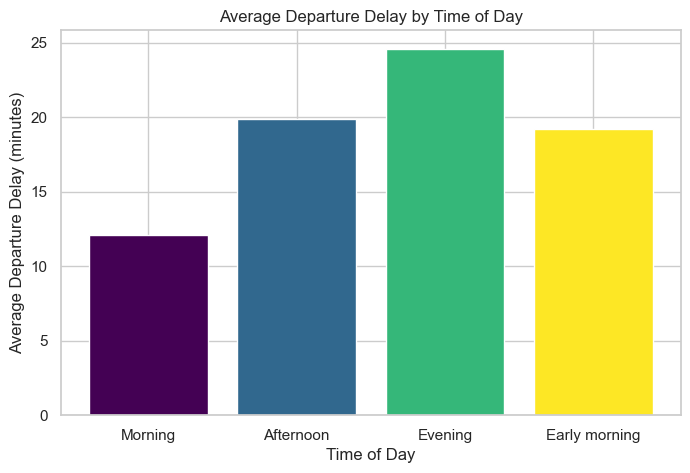

In [326]:
delay_by_time=pd.DataFrame({'TimeOfDay':['Morning','Afternoon','Evening','Early morning'],
                            'AvgDelay':[12.1,19.9,24.6,19.2]})
plt.figure(figsize=(8,5))
colors = plt.cm.viridis(np.linspace(0,1,len(delay_by_time)))
plt.bar(delay_by_time['TimeOfDay'], delay_by_time['AvgDelay'],color=colors)
plt.title('Average Departure Delay by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()




From the data and visualizatiI, we observe the followig:

- **Morning** flights have the lowest average delay, about 12.1 minutes.
- **Afternoon** flights have higher delays, averaging around 19.9 minutes.
- **Evening** flights experience the highest average delay, approximately 24.6 minutes.
- **Early morning** flights have an average delay of about 19.2 minutes, which falls between morning and afternoonre delays.

There are several possible reasns for this:

- Morning flights often depart first and have fewer delays carried over from earlier flights.
- Delays accumulate during the day due to airport congestion and late arrivals of previous flights, affecting afternoon and evening flights.
- Early morning flights may have fewer delays than afternoon flights because there is n to reduce delays.


### Average Delay by Day of Week

In [269]:
query_day_of_week="""
SELECT
  DayOfWeek,
  AVG(DepDelay) AS AvgDepDelay
FROM airlines_2004
WHERE DepDelay IS NOT NULL AND DepDelay >= 0
GROUP BY DayOfWeek
ORDER BY DayOfWeek
"""

cursor.execute(query_day_of_week)
results_day=cursor.fetchall()
print(results_day)

[(1, 19.498064815279395), (2, 17.220585810222964), (3, 18.302145457649384), (4, 19.415220778773556), (5, 19.080053091650132), (6, 15.287750814429218), (7, 18.736324418880454)]


I used the SQL query calculates the average departure delay (`DepDelay`) for each day of the week. It filters out records with null or negative delay values to ensure the data's reliability. The results are then grouped and ordered by the day of the week, where 1 represents Monday and 7 represents Sunday.

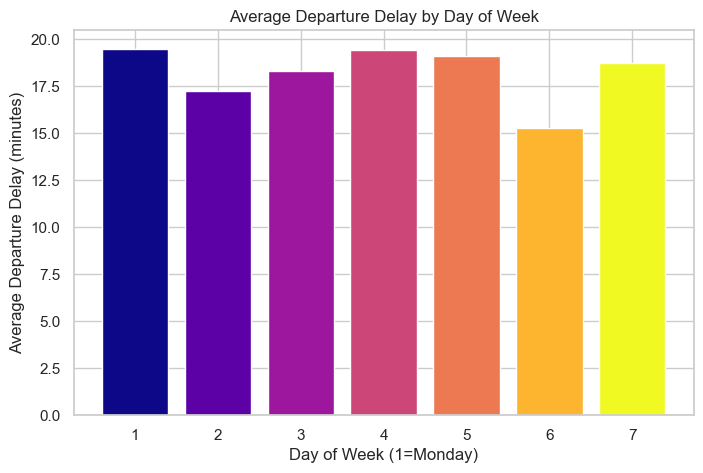

In [270]:
df_day=pd.DataFrame(results_day,columns=['DayOfWeek','AvgDepDelay'])
plt.figure(figsize=(8,5))
colors=plt.cm.plasma(np.linspace(0,1,len(df_day)))
plt.bar(df_day['DayOfWeek'].astype(str),df_day['AvgDepDelay'],color=colors)
plt.title('Average Departure Delay by Day of Week')
plt.xlabel('Day of Week (1=Monday)')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()

From the data and chart, I observe:

- Monday (Day 1) has one of the highest average delays, around 19.5 minutes.
- Tuesday through Friday (Days 2 to 5) show slightly lower delays, roughly between 17 and 19 minutes.
- Saturday (Day 6) has the lowest average delay, about 15.3 minutes.
- Sunday (Day 7) sees delays rise again to approximately 18.7 minutes.utes.tes.
ek.


Weekends, especially Saturday, tend to have better on-time performance compared to weekdays. Monday experiences the longest delays, possibly due to accumulated delays from the weekend or increased flight volume.

### Average Delay by Month

In [271]:
query_month="""
SELECT
  Month,
  AVG(DepDelay) AS AvgDepDelay
FROM airlines_2004
WHERE DepDelay IS NOT NULL AND DepDelay >= 0
GROUP BY Month
ORDER BY Month
"""

cursor.execute(query_month)
results_month=cursor.fetchall()
print(results_month)

[(1, 18.26678200479002), (2, 16.751524354709264), (3, 15.448992730320713), (4, 14.065688056041559), (5, 19.745338897701235), (6, 21.462767314285074), (7, 19.99172128978759), (8, 19.82913066316077), (9, 14.628170563326654), (10, 15.428290439919369), (11, 18.65619375756046), (12, 23.053830453198863)]


I use the SQL query calculates the average departure delay (`DepDelay`) for each month of the year. It excludes flights with null or negative delay values to maintain data quality. The results are grouped by month and ordered from January (1) to December (12).

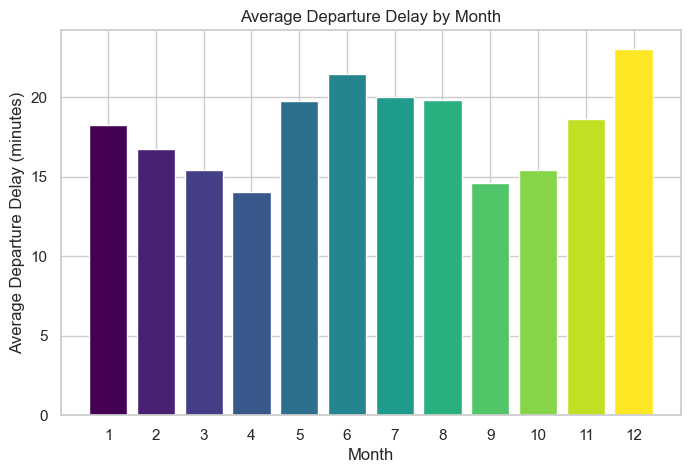

In [272]:
df_month=pd.DataFrame(results_month,columns=['Month','AvgDepDelay'])
plt.figure(figsize=(8,5))
colors = plt.cm.viridis(np.linspace(0, 1, len(df_month)))
plt.bar(df_month['Month'].astype(str), df_month['AvgDepDelay'], color=colors)
plt.title('Average Departure Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()

From the chart and data, I observe:

- June (Month 6) has one of the highest average delays, around 21.5 minutes.
- December (Month 12) shows the highest average delay, approximately 23.5 minutes.
- May, July, and August (Months 5, 7, 8) also have relatively high delays, close to 20 minutes.
- April and September (Months 4 and 9) show the lowest average delays, around 14 to 15 minutes.
- The delay tends to increase towards the end of the year, peaking in December.

These monthly delay patterns may reflect several factors:

- **Seasonal travel demand**: Summer months (May to August) and December typically experience higher passenger volumes, which can strain airport operations and increase delays.
- **Weather conditions**: Winter months, especially December, often face adverse weather such as snow and ice, which can disrupt flight schedules and cause delays.
- **Holiday travel peaks**: December is a major holiday season, leading to more flights and higher chances of congestion and delays.
- **Operational challenges**: Airports and airlines may face logistical difficulties during peak months, impacting on-time performance.educe delays.


### Average Delay by Season

In [323]:
season_map={12:'Winter',1:'Winter',2:'Winter',
            3:'Spring',4:'Spring',5:'Spring',
            6:'Summer',7:'Summer',8:'Summer',
            9:'Autumn',10:'Autumn',11:'Autumn'}
df_month['Season']=df_month['Month'].map(season_map)

I groups the monthly average departure delays into four seasons: Winter, Spring, Summer, and Autumn. The mapping assigns months to their corresponding seasons based on typical Northern Hemisphere divisions.

In [324]:
season_delay=df_month.groupby('Season')['AvgDepDelay'].mean().reindex(['Winter','Spring','Summer','Autumn'])
print(season_delay)

Season
Winter    19.357379
Spring    16.420007
Summer    20.427873
Autumn    16.237552
Name: AvgDepDelay, dtype: float64


The average departure delay for each season is calculated by taking the mean of the monthly average delays within that season. 

C:\Users\PC 21\AppData\Local\Temp\ipykernel_12884\957883264.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_delay.index, y=season_delay.values, palette='coolwarm')


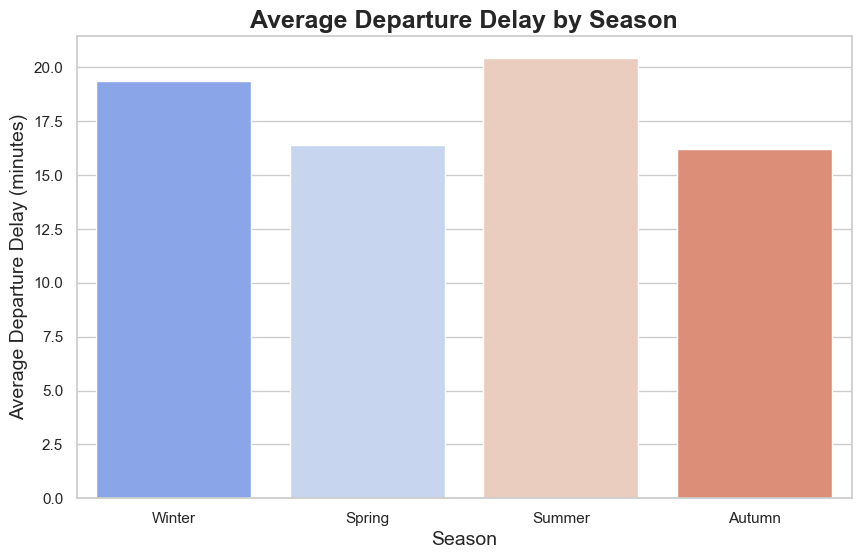

In [325]:
plt.figure(figsize=(10,6))
sns.barplot(x=season_delay.index, y=season_delay.values, palette='coolwarm')
plt.title('Average Departure Delay by Season', fontsize=18, weight='bold')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Departure Delay (minutes)', fontsize=14)
plt.show()

These seasonal patterns may be influenced by several factors:

- **Summer delays** might be driven by increased travel demand during vacation months, causing airport congestion and operational stress.
- **Winter delays** are often related to adverse weather conditions such as snw, ie, and fog, which can disrupt flight schedules.
- **Spring and Autumn** tend to have milder weather and lower passenger volumes, resulting in fewer delays on average.

## 2. Delay Factors

In [273]:
query="""
SELECT
  SUM(CarrierDelay) AS CarrierDelay,
  SUM(WeatherDelay) AS WeatherDelay,
  SUM(NASDelay) AS NASDelay,
  SUM(SecurityDelay) AS SecurityDelay,
  SUM(LateAircraftDelay) AS LateAircraftDelay
FROM airlines_2004
WHERE DepDelay IS NOT NULL AND DepDelay > 0
"""

cursor.execute(query)
result=cursor.fetchone()

I examines the main factors contributing to flight delays by summing total delay minutes for each cause.The factors include Carrier Delay,Weather Delay,National Air System (NAS) Delay,Security Delay,and Late Aircraft Delay.Only flights with positive departure delays (`DepDelay > 0`) are considered to ensure the accuracy of delay attribution.

In [274]:
factors=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
values=list(result)

df_factors=pd.DataFrame({'Factor':factors,'DelayMinutes':values})
df_factors['Percentage']=df_factors['DelayMinutes']/df_factors['DelayMinutes'].sum()*100

df_factors=df_factors.sort_values(by='DelayMinutes',ascending=False)

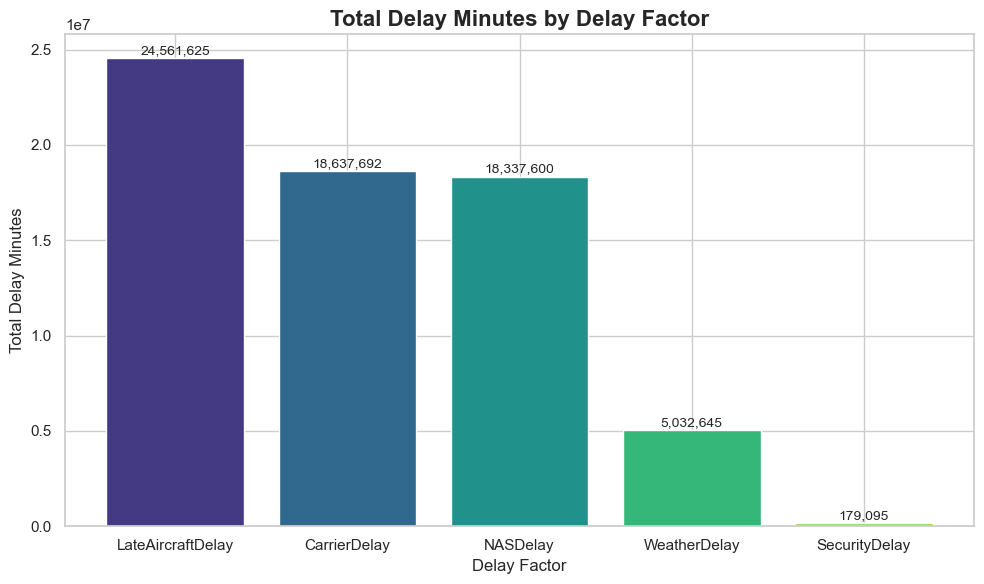

In [275]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
bars = plt.bar(df_factors['Factor'],df_factors['DelayMinutes'],color=sns.color_palette("viridis",len(df_factors)))
plt.title('Total Delay Minutes by Delay Factor',fontsize=16,weight='bold')
plt.ylabel('Total Delay Minutes',fontsize=12)
plt.xlabel('Delay Factor',fontsize=12)
for bar in bars:
    yval=bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2,yval+50000,f'{int(yval):,}',ha='center',va='bottom',fontsize=10)
plt.tight_layout()
plt.show()

From the chart,I observe the following:

- **Late Aircraft Delay** accounts for the largest share of total delay minutes,with approximately 24.56 million minutes.This indicates that delays caused by previous flights running late have the greatest impact.
- **Carrier Delay** and **NAS Delay** follow closely,contributing around 18.6 million and 18.3 million delay minutes respectively.Carrier Delay relates to issues within the airline's control,such as maintenance or crew problems,while NAS Delay stems from air traffic control and airspace restrictions.
- **Weather Delay** contributes about 5 million minutes,reflecting the impact of adverse weather conditions.
- **Security Delay** has the smallest share,with just under 180 thousand delay minutes.


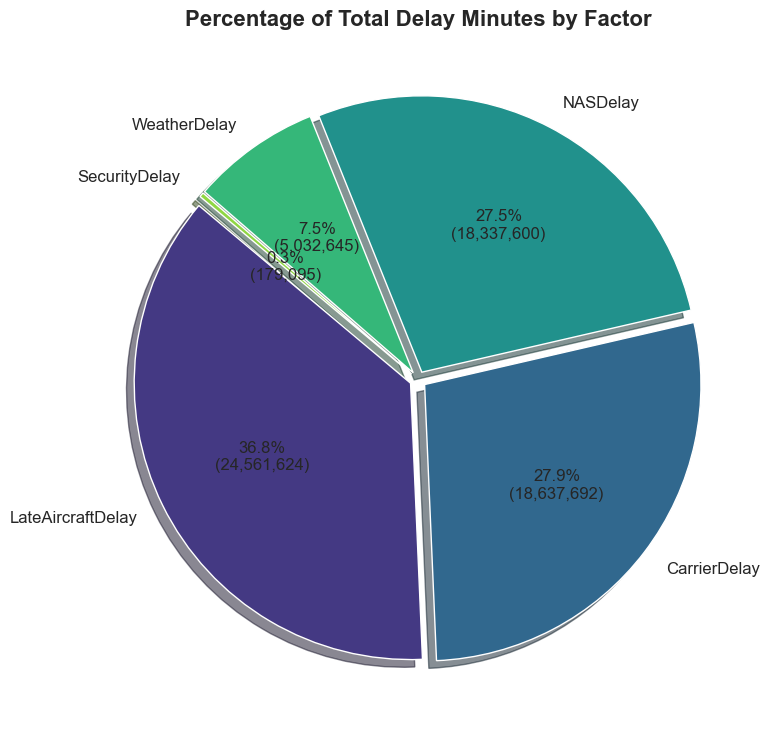

In [276]:
plt.figure(figsize=(8,8))
explode=[0.03]*len(df_factors)  
colors=sns.color_palette("viridis",len(df_factors))

def autopct_format(pct):
    total=sum(df_factors['DelayMinutes'])
    val=int(round(pct*total/100.0))
    return f'{pct:.1f}%\n({val:,})'

plt.pie(df_factors['DelayMinutes'],labels=df_factors['Factor'],autopct=autopct_format,startangle=140,
        explode=explode,shadow=True,colors=colors,textprops={'fontsize':12})

plt.title('Percentage of Total Delay Minutes by Factor',fontsize=16,weight='bold')
plt.tight_layout()
plt.show()

The percentage distribution of total delay minutes by factor:

- Late Aircraft Delay makes up about 36.8% of total delay minutes.
- Carrier Delay and NAS Delay represent roughly 27.9% and 27.5%.
- Weather Delay accounts for approximately 7.5%.
- Security Delay contributes a negligible portion at around 0.3%.

Operational issues related to aircraft scheduling and airline management are the leading causes of delays.Weather and security issues,while important,contribute less overall.

In [277]:
print(df_factors)

              Factor  DelayMinutes  Percentage
4  LateAircraftDelay      24561625   36.797182
0       CarrierDelay      18637692   27.922198
2           NASDelay      18337600   27.472613
1       WeatherDelay       5032645    7.539695
3      SecurityDelay        179095    0.268313


### Strongly Correlated Variables and Plots

In [293]:
# Get all numeric columns
query="""
SELECT DepDelay,ArrDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Distance,TaxiIn,TaxiOut
FROM airlines_2004
LIMIT 100000
"""
cursor.execute(query)
results=cursor.fetchall()
columns=['DepDelay','ArrDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','Distance','TaxiIn','TaxiOut']
df_full=pd.DataFrame(results,columns=columns)

In [294]:
# Calculate the correlation matrix
corr_matrix=df_full.corr()

In [295]:
# Find strong correlations (absolute values ​​> 0.5 and not 1.0)
strong_corrs=[]
for i in corr_matrix.columns:
    for j in corr_matrix.index:
        if i !=j and abs(corr_matrix.loc[j,i])>0.5:
            strong_corrs.append((i,j,corr_matrix.loc[j,i]))

print("Strong correlations (|corr|>0.5):")
for pair in strong_corrs:
    print(pair)

Strong correlations (|corr|>0.5):
('DepDelay', 'ArrDelay', 0.9029125132920713)
('DepDelay', 'CarrierDelay', 0.5041243459754827)
('DepDelay', 'LateAircraftDelay', 0.7385276661665696)
('ArrDelay', 'DepDelay', 0.9029125132920713)
('ArrDelay', 'NASDelay', 0.5942566338869482)
('ArrDelay', 'LateAircraftDelay', 0.6667368029476096)
('CarrierDelay', 'DepDelay', 0.5041243459754827)
('NASDelay', 'ArrDelay', 0.5942566338869482)
('NASDelay', 'TaxiOut', 0.541260932891525)
('LateAircraftDelay', 'DepDelay', 0.7385276661665696)
('LateAircraftDelay', 'ArrDelay', 0.6667368029476096)
('TaxiOut', 'NASDelay', 0.541260932891525)


The relationships between key numeric variables related to flight delays.The selected variables include departure delay (`DepDelay`),arrival delay (`ArrDelay`),and various delay causes such as Carrier Delay,Weather Delay,NAS Delay,Security Delay,Late Aircraft Delay,along with Distance,Taxi-In,and Taxi-Out times.

A correlation matrix was calculated for these variables using a sample of 100,000 records.Strong correlations were identified where the absolute correlation coefficient exceeds 0.5 (excluding self-correlations).

- `DepDelay` and `ArrDelay` (0.90):Departure and arrival delays are very closely related,as expected.Delays at departure often lead to similar delays upon arrival.
- `DepDelay` and `CarrierDelay` (0.50):Carrier-related issues significantly impact departure delays.
- `DepDelay` and `LateAircraftDelay` (0.74):Delays caused by late incoming aircraft strongly influence departure delays.
- `ArrDelay` and `NASDelay` (0.59):National Air System delays have a moderate correlation with arrival delays.
- `NASDelay` and `TaxiOut` (0.54):Delays in the National Air System correlate moderately with taxi-out times.
t times.mes.).

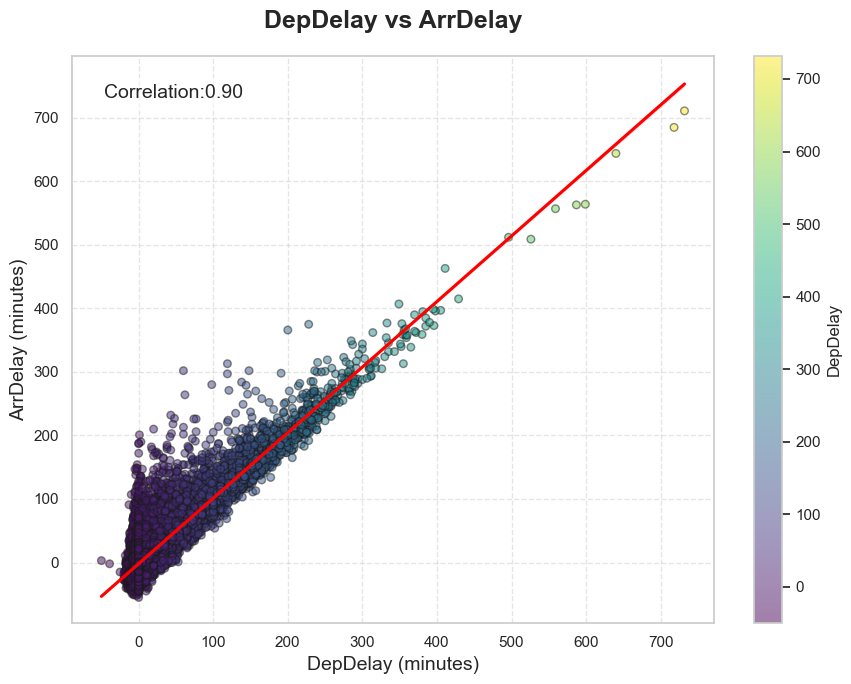

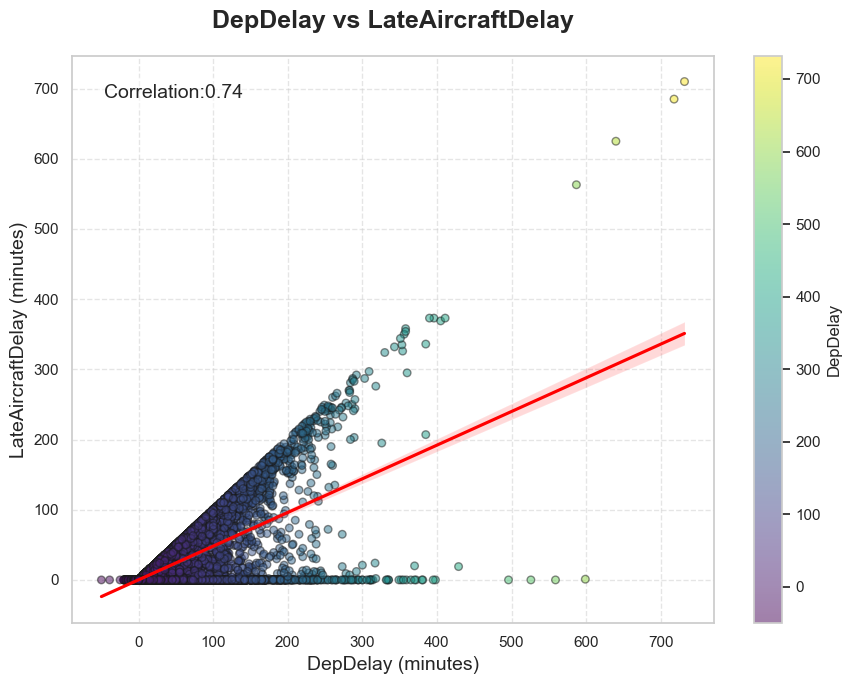

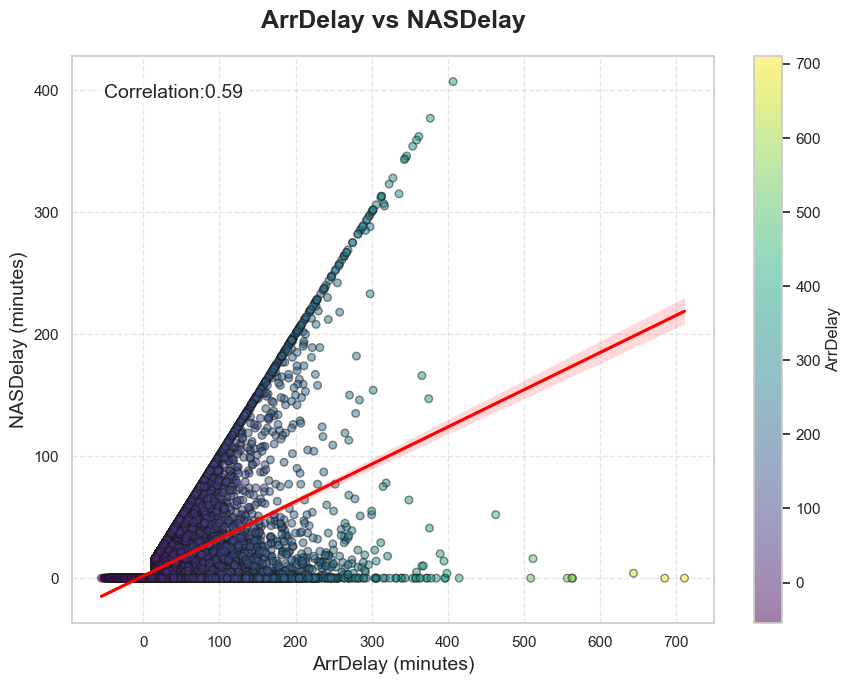

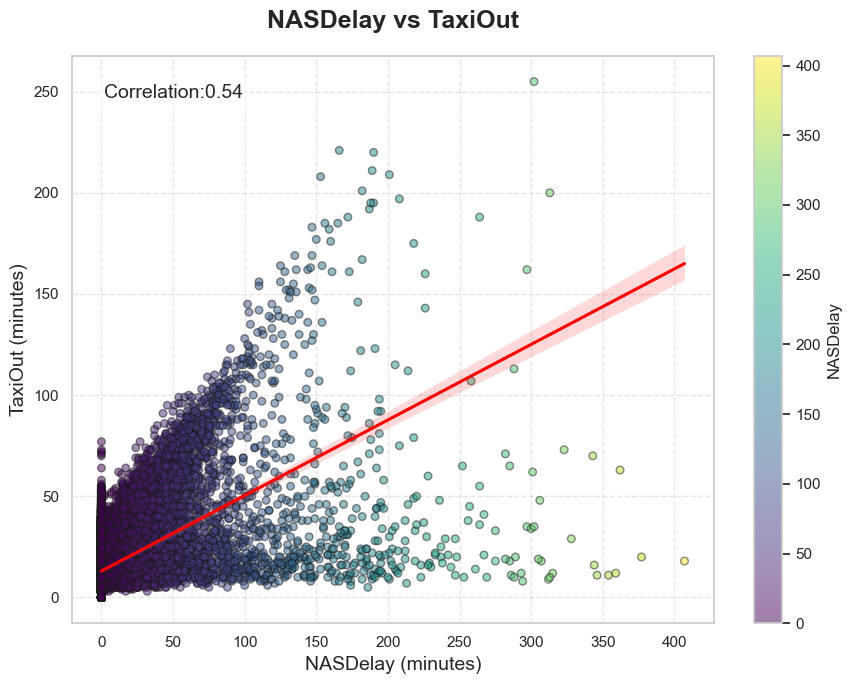

In [302]:
pairs=[('DepDelay','ArrDelay'),
       ('DepDelay','LateAircraftDelay'),
       ('ArrDelay','NASDelay'),
       ('NASDelay','TaxiOut')]

for x_var,y_var in pairs:
    plt.figure(figsize=(9,7))
    sc=plt.scatter(df_full[x_var],df_full[y_var],c=df_full[x_var],cmap='viridis',alpha=0.5,edgecolor='k',s=30)
    plt.colorbar(sc,label=x_var)
    sns.regplot(data=df_full,x=x_var,y=y_var,scatter=False,line_kws={'color':'red'})
    corr=df_full[x_var].corr(df_full[y_var])
    plt.title(f'{x_var} vs {y_var}',fontsize=18,weight='bold',pad=20)
    plt.xlabel(f'{x_var} (minutes)',fontsize=14)
    plt.ylabel(f'{y_var} (minutes)',fontsize=14)
    plt.grid(True,linestyle='--',alpha=0.5)
    plt.text(0.05,0.95,f'Correlation:{corr:.2f}',transform=plt.gca().transAxes,fontsize=14,verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.3',facecolor='white',alpha=0.5))
    plt.tight_layout()
    plt.show()

- The plot of `DepDelay` vs. `ArrDelay` shows a strong positive linear relationship,delayed departures usually result in delayed arrivals.
- The plot of `DepDelay` vs. `LateAircraftDelay` indicates a positive correlation,showing how late arrivals of aircraft affect subsequent departure delays.
- The plot of `ArrDelay` vs. `NASDelay` demonstrates a moderate positive relationship,air traffic control and airspace restrictions contribute to arrival delays.
- The plot of `NASDelay` vs. `TaxiOut` reveals a moderate correlation,delays in the National Air System may increase the time aircraft spend taxiing out before takeoff.

## 3. Cancellation Analysis

### Statistics cancellation reason

The data includes all flights that were marked as cancelled (`Cancelled = 1`) in the year 2004.

I used the SQL query groups cancellations by their cancellation code and counts the number of cancellations for each reason.

In [280]:
query = """
SELECT CancellationCode, COUNT(*) AS CancelCount
FROM airlines_2004
WHERE Cancelled = 1
GROUP BY CancellationCode
ORDER BY CancelCount DESC
"""

cursor.execute(query)
results = cursor.fetchall()

df_cancel_reason=pd.DataFrame(results,columns=['CancellationCode','CancelCount'])
print(df_cancel_reason)

  CancellationCode  CancelCount
0                A        59352
1                B        44558
2                C        23732
3                D          115


C:\Users\PC 21\AppData\Local\Temp\ipykernel_12884\3349897394.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_cancel_reason,x='CancellationCode',y='CancelCount',palette='pastel')


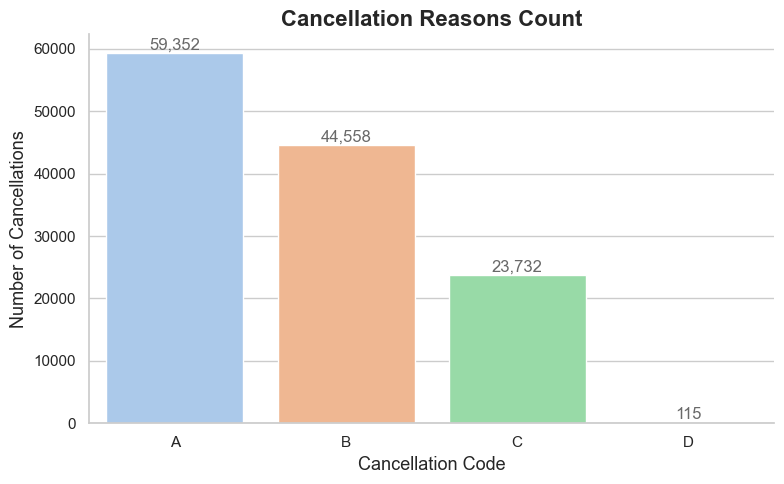

In [281]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
ax = sns.barplot(data=df_cancel_reason,x='CancellationCode',y='CancelCount',palette='pastel')
plt.title('Cancellation Reasons Count',fontsize=16,weight='bold')
plt.xlabel('Cancellation Code',fontsize=13)
plt.ylabel('Number of Cancellations',fontsize=13)
for i,v in enumerate(df_cancel_reason['CancelCount']):
    plt.text(i,v+df_cancel_reason['CancelCount'].max()*0.01,f'{v:,}',ha='center',fontsize=12,color='dimgrey')
sns.despine()
plt.tight_layout()
plt.show()

- **Code A** has the highest number of cancellations,with 59352 flights cancelled.
- **Code B** accounting for 44558 cancellations.
- **Code C** is the third most common reason,with 23732 cancellations.
- **Code D** has the fewest cancellations,only 115 cases.

Although the exact meanings of each cancellation code are not provided here,these codes typically represent reasons such as carrier-related issues,weather conditions,National Air System delays,or security concerns.

Carrier or operational issues (often represented by Code A) are the leading cause of cancellations.Weather or air traffic control issues may correspond to Codes B and C,which also have substantial counts.

### Count the number of flight cancellations by airlines

In [212]:
query_carrier = """
SELECT UniqueCarrier,COUNT(*) AS CancelCount
FROM airlines_2004
WHERE Cancelled=1
GROUP BY UniqueCarrier
ORDER BY CancelCount DESC
"""

cursor.execute(query_carrier)
results_carrier=cursor.fetchall()

df_carrier=pd.DataFrame(results_carrier,columns=['UniqueCarrier','CancelCount'])
print(df_carrier)

   UniqueCarrier  CancelCount
0             MQ        17787
1             OH        13616
2             AA        12402
3             DL        10717
4             WN        10103
5             OO         9784
6             DH         8287
7             EV         7542
8             US         6779
9             UA         6548
10            XE         6103
11            NW         6010
12            AS         3670
13            HP         3108
14            FL         2013
15            CO         1898
16            TZ          717
17            B6          511
18            HA          162


The SQL query groups cancellations by the unique carrier code and orders them by the number of cancellations in descending order.

C:\Users\PC 21\AppData\Local\Temp\ipykernel_12884\3698981557.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=df_carrier,x='UniqueCarrier',y='CancelCount',palette='Blues_r')


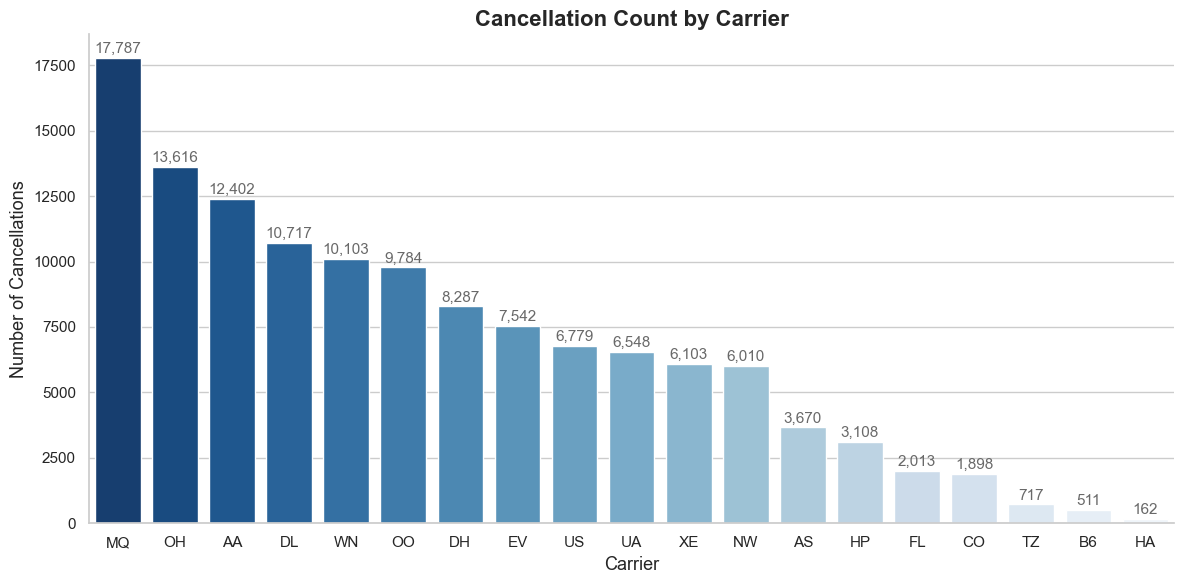

In [327]:
plt.figure(figsize=(12,6))
ax=sns.barplot(data=df_carrier,x='UniqueCarrier',y='CancelCount',palette='Blues_r')
plt.title('Cancellation Count by Carrier',fontsize=16,weight='bold')
plt.xlabel('Carrier',fontsize=13)
plt.ylabel('Number of Cancellations',fontsize=13)
for i, v in enumerate(df_carrier['CancelCount']):
    plt.text(i,v+df_carrier['CancelCount'].max()*0.01,f'{v:,}',ha='center',fontsize=11,color='dimgrey')
sns.despine()
plt.tight_layout()
plt.show()

- The carrier with code **MQ** has the highest number of cancellations,totaling 17787 flights.
- The next highest are **OH** with 13616 cancellations and **AA** with 12402 cancellations.
- Other carriers such as **DL**, **WN**, **OO**,and **DH** also have a significant number of cancellations,ranging from around 7500 to 10700.
- Several carriers have much fewer cancellations,with the lowest around a few hundred.

These differences might reflect the size of the airlines,their network complexity,and operational challenges faced during the year.

### Comparison of various cancellation reasons across different airlines

In [188]:
query = """
SELECT UniqueCarrier,CancellationCode,COUNT(*) AS CancelCount
FROM airlines_2004
WHERE Cancelled=1
GROUP BY UniqueCarrier,CancellationCode
"""
cursor.execute(query)
results=cursor.fetchall()
df_grouped=pd.DataFrame(results,columns=['UniqueCarrier','CancellationCode','CancelCount'])

In [219]:
order = ['A', 'B', 'C', 'D']
df_grouped['CancellationCode'] = pd.Categorical(df_grouped['CancellationCode'], categories=order, ordered=True)

In [223]:
# Calculate the total number of cancellations for each airline
carrier_order=df_grouped.groupby('UniqueCarrier')['CancelCount'].sum().sort_values(ascending=False).index

In [224]:
# Set UniqueCarrier to ordered classification, sorted by total cancellation count
df_grouped['UniqueCarrier']=pd.Categorical(df_grouped['UniqueCarrier'],categories=carrier_order,ordered=True)

Comparing the distribution of different cancellation reasons across various airline carriers in 2004.The data includes all cancelled flights,grouped by unique carrier and cancellation code.

The SQL query counts cancellations by both carrier and cancellation reason.The cancellation codes are ordered as A,B,C,and D for consistency.

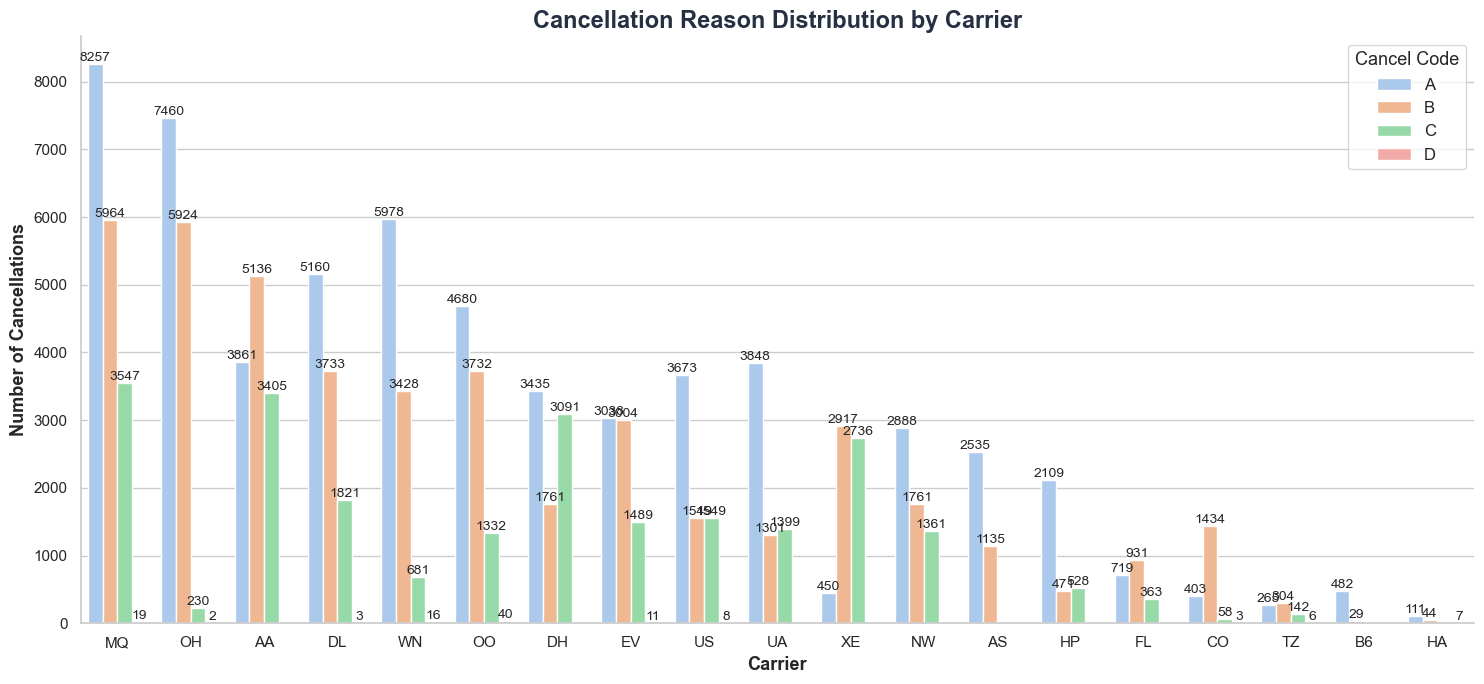

In [226]:
plt.figure(figsize=(15,7))
ax=sns.barplot(data=df_grouped,x='UniqueCarrier',y='CancelCount',hue='CancellationCode',palette='pastel',hue_order=order)
plt.title('Cancellation Reason Distribution by Carrier',fontsize=17,weight='bold',color='#273043')
plt.xlabel('Carrier',fontsize=13,weight='bold')
plt.ylabel('Number of Cancellations',fontsize=13,weight='bold')
plt.legend(title="Cancel Code",fontsize=12,title_fontsize=13)
for c in ax.containers:
    ax.bar_label(c,label_type='edge',fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()

- Carrier **MQ** has the highest number of cancellations across all reasons,with a particularly large number under code A.
- Carriers **OH**,**AA**,**DL**,and **WN** also have significant cancellation counts for all cancellation codes.
- Most carriers show a similar pattern,where cancellation reason A dominates,followed by B and C.
- Cancellation code D consistently accounts for the fewest cancellations across carriers.

Certain cancellation reasons are more prevalent regardless of the airline,while the total volume of cancellations varies by carrier size and operations.

### Airport cancellations

In [5]:
query="""
SELECT Origin,COUNT(*) AS CancelledCount
FROM airlines_2004
WHERE Cancelled=1
GROUP BY Origin
ORDER BY CancelledCount DESC
LIMIT 15
"""
cursor.execute(query)
results_airport=cursor.fetchall()

Identifing the airports with the highest number of flight cancellations.The data includes all flights in 2004 that were marked as cancelled.The SQL query groups cancellations by the origin airport and lists the top 15 airports with the most cancellations.

C:\Users\PC 21\AppData\Local\Temp\ipykernel_16228\244031845.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Origin',y='CancelledCount',data=df_cancel_airport,


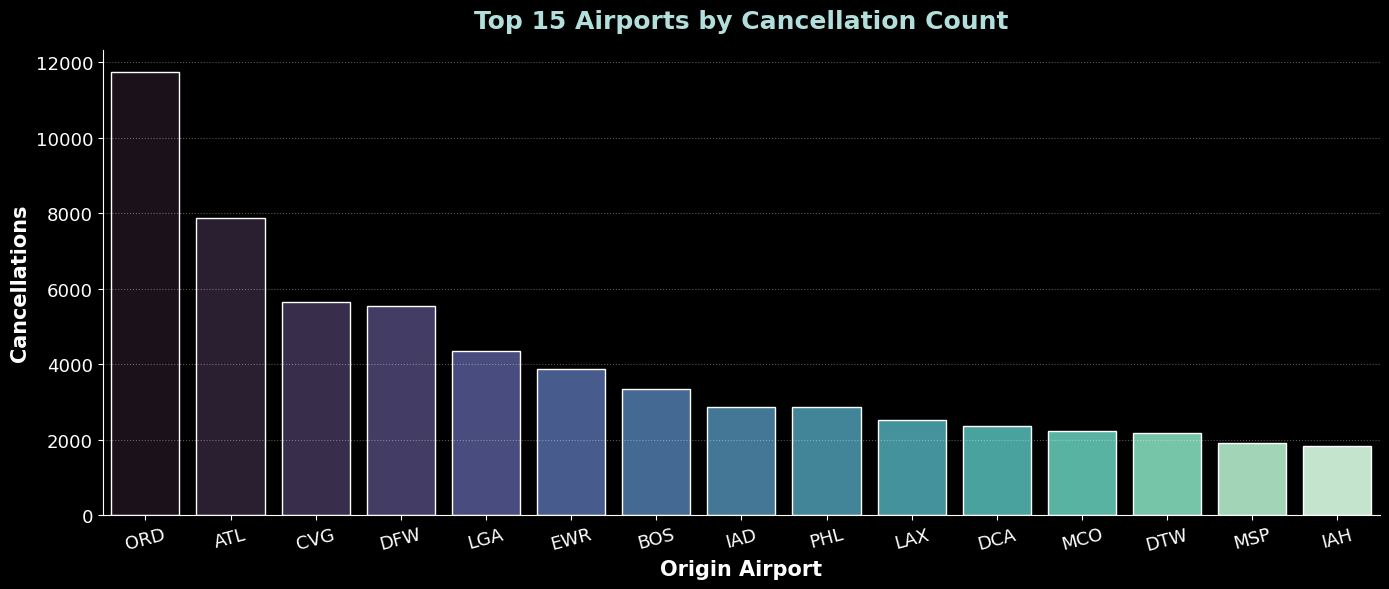

In [12]:
plt.style.use('dark_background')
plt.figure(figsize=(14,6))
sns.barplot(x='Origin',y='CancelledCount',data=df_cancel_airport,
    palette='mako',edgecolor='w')
plt.title('Top 15 Airports by Cancellation Count',fontsize=18,weight='bold',color='#B2DFDB',pad=16)
plt.xlabel('Origin Airport',fontsize=15,weight='bold')
plt.ylabel('Cancellations',fontsize=15,weight='bold')
plt.xticks(fontsize=13,rotation=15)
plt.yticks(fontsize=13)
sns.despine()
plt.tight_layout()
plt.grid(axis='y',linestyle=':',alpha=0.35)
plt.show()
plt.style.use('default')  

- **ORD (Chicago O'Hare)** has the highest number of cancellations,with almost 12000 cancelled flights.
- **ATL (Atlanta)** is next,with nearly 8000 cancellations.
- Other major airports,such as **CVG (Cincinnati)**,**DFW (Dallas/Fort Worth)**,and **LGA (LaGuardia)**,also report a high number of cancellations.
- The remaining airports on the list,including **EWR (Newark)**,**BOS (Boston)**, **IAD (Washington Dulles)**,and others,have cancellation counts ranging from about 2000 to 4000.

Large hub airports tend to experience more cancellations.This is likely due to their high traffic volume,complex operations,and potential exposure to weather and congestion-related issues.

### Monthly Cancellations

In [24]:
query="""
SELECT Month,COUNT(*) AS CancelledCount
FROM airlines_2004
WHERE Cancelled=1
GROUP BY Month
ORDER BY Month
"""
cursor.execute(query)
results_month=cursor.fetchall()

Examining the number of flight cancellations for each month of 2004.The SQL query counts the total cancelled flights per month and orders the results.

C:\Users\PC 21\AppData\Local\Temp\ipykernel_16228\305998376.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


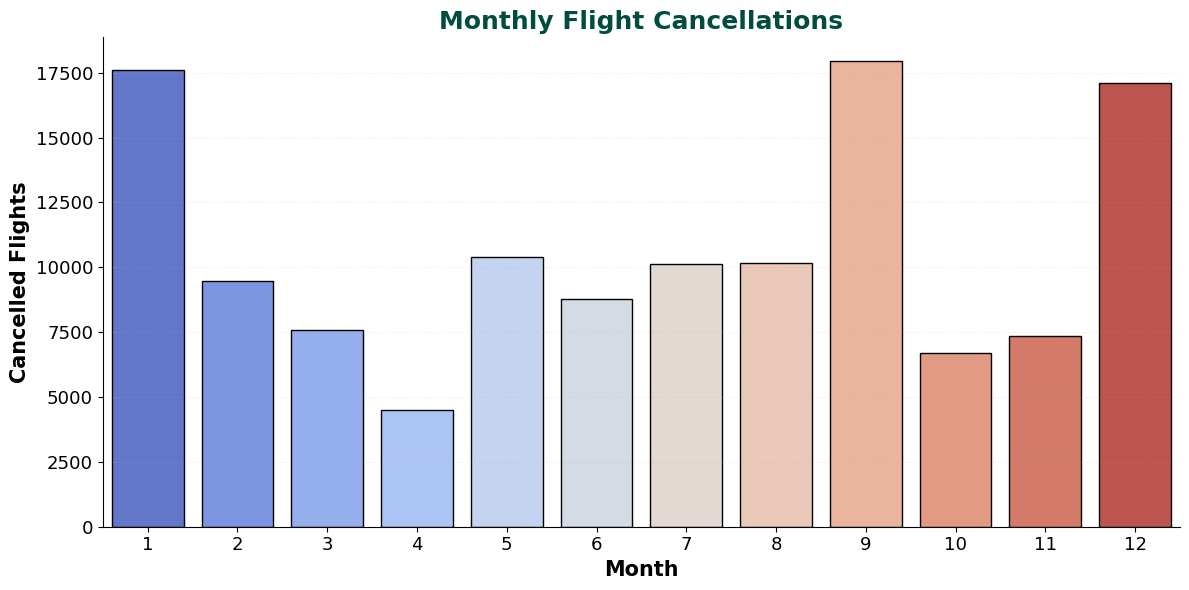

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Month', y='CancelledCount', data=df_cancel_month, 
    palette=sns.color_palette("coolwarm", n_colors=len(df_cancel_month)),
    edgecolor='k'
)
plt.title('Monthly Flight Cancellations', fontsize=18, weight='bold', color='#004d40')
plt.xlabel('Month', fontsize=15, weight='bold')
plt.ylabel('Cancelled Flights', fontsize=15, weight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y', linestyle=':', alpha=0.25)
sns.despine()
plt.tight_layout()
plt.show()

- **January** and **September** have the highest number of cancellations,each exceeding 17000 flights.
- **December** also shows a high number of cancellations,slightly below January and September.
- **April** has the lowest number of cancellations,with fewer than 5000 cancelled flights.
- The remaining months show moderate levels of cancellations,generally ranging from about 7000 to 11000.

These monthly variations may be influenced by several factors.Winter months like January and December often face adverse weather,increasing the risk of flight disruptions.September stands out as another peak month for cancellations,which could be related to seasonal storms or operational changes at the end of the summer travel season.

### Monthly Cancellation Rate

Shows how the flight cancellation rate changes month by month in 2004.The cancellation rate is calculated as the number of cancelled flights divided by the total number of flights for each month.

In [31]:
query = """
SELECT Month,
       COUNT(*) AS TotalFlights,
       SUM(Cancelled) AS CancelledFlights,
       SUM(Cancelled)/COUNT(*) AS CancelledRate
FROM airlines_2004
GROUP BY Month
ORDER BY Month
"""
cursor.execute(query)
results_cancel_rate=cursor.fetchall()

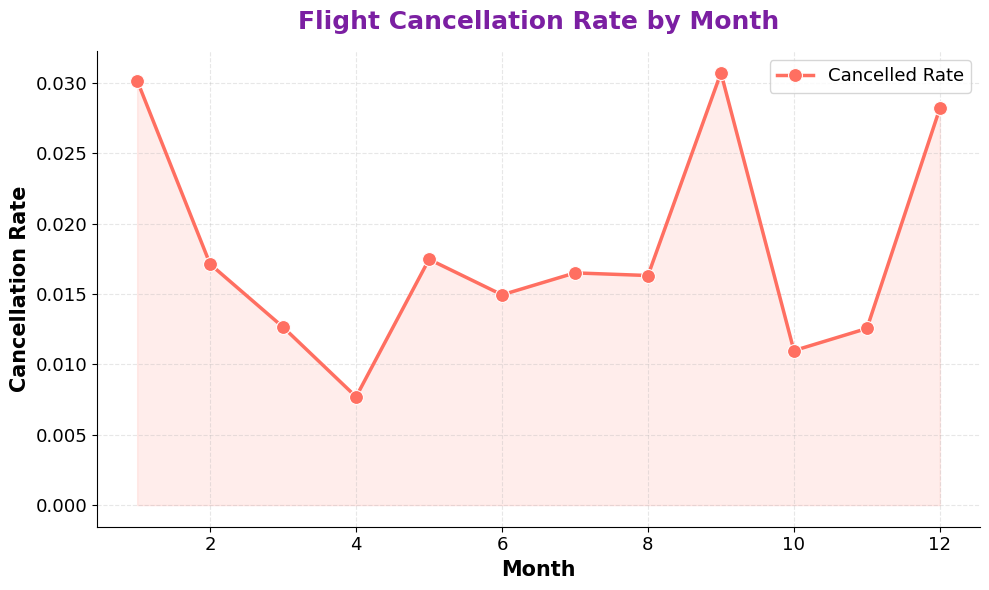

In [32]:
df_cancel_rate=pd.DataFrame(results_cancel_rate,columns=['Month','TotalFlights','CancelledFlights','CancelledRate'])
plt.figure(figsize=(10,6))
sns.lineplot(x='Month',y='CancelledRate',
             data=df_cancel_rate,
             marker='o',markersize=10,linewidth=2.5,
             color='#FF6F61',label='Cancelled Rate')

plt.fill_between(df_cancel_rate['Month'],df_cancel_rate['CancelledRate'],color='#FF6F61',alpha=0.12)
plt.title('Flight Cancellation Rate by Month',fontsize=18,weight='bold',color='#7B1FA2',pad=16)
plt.xlabel('Month',fontsize=15,weight='bold')
plt.ylabel('Cancellation Rate',fontsize=15,weight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(linestyle='--', alpha=0.3)
sns.despine()
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

- **January** and **September** have the highest cancellation rates,both slightly above 3%.
- **December** also shows a high cancellation rate,close to 3%.
- **April** has the lowest cancellation rate,at around 0.8%.
- Most other months maintain a cancellation rate between 1% and 2%.
- There is a noticeable increase in cancellation rates during the winter months and in September.

Weather and seasonal factors might play a significant role in flight cancellations,especially in winter and early fall.Other possible influences include changes in travel demand,airline schedules,and operational challenges during these periods.

## 4. Problematic Routes

### Find the top 10 routes with the most delays

In [190]:
query_routes_delay = """
SELECT Origin,Dest,COUNT(*) AS FlightCount,AVG(DepDelay) AS AvgDepDelay,AVG(ArrDelay) AS AvgArrDelay
FROM airlines_2004
WHERE DepDelay IS NOT NULL AND DepDelay>0
GROUP BY Origin,Dest
ORDER BY AvgDepDelay DESC
LIMIT 10
"""

cursor.execute(query_routes_delay)
results_routes_delay=cursor.fetchall()

df_routes_delay=pd.DataFrame(results_routes_delay,columns=['Origin','Dest','FlightCount','AvgDepDelay','AvgArrDelay'])
print(df_routes_delay)

  Origin Dest  FlightCount  AvgDepDelay  AvgArrDelay
0    EUG  TWF            1        522.0          NaN
1    TYS  SDF            1        373.0        318.0
2    BIS  FAR            1        369.0        318.0
3    MCI  SGF            1        355.0        245.0
4    LNK  COS            1        316.0        241.0
5    LNK  OMA            1        308.0        147.0
6    PSP  SAN            1        272.0        276.0
7    BIS  ORD            1        270.0          NaN
8    LAS  SGU            2        263.0        212.5
9    OAK  FAT            1        258.0        273.0


Identificing the top 10 flight routes with the highest average departure delays in 2004.The query selects routes based on origin and destination airports,counting the number of flights and calculating the average departure and arrival delays for each route.Only flights with valid positive departure delays are included.

C:\Users\PC 21\AppData\Local\Temp\ipykernel_12884\1542999127.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=df_routes_delay,x='Route',y='AvgDepDelay',palette=palette)


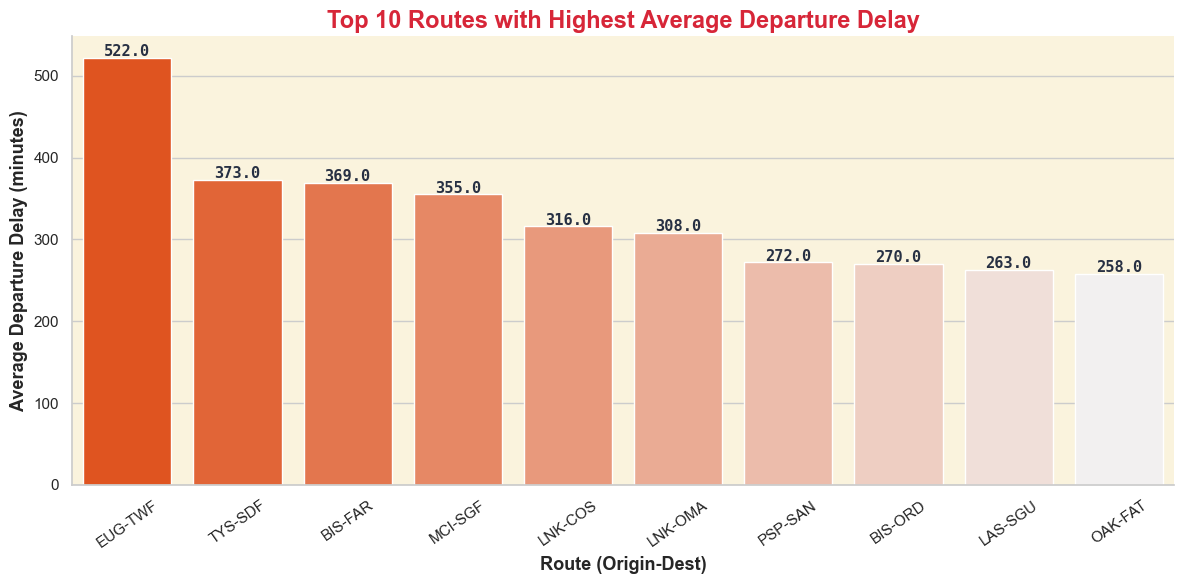

In [192]:
df_routes_delay['Route']=df_routes_delay['Origin']+'-'+df_routes_delay['Dest']

palette=sns.light_palette("orangered",n_colors=len(df_routes_delay),reverse=True)
plt.figure(figsize=(12,6))
ax=sns.barplot(data=df_routes_delay,x='Route',y='AvgDepDelay',palette=palette)
plt.title('Top 10 Routes with Highest Average Departure Delay',fontsize=17,weight='bold',color='#D72638')
plt.xlabel('Route (Origin-Dest)',fontsize=13,weight='bold')
plt.ylabel('Average Departure Delay (minutes)',fontsize=13,weight='bold')
plt.xticks(rotation=35,fontsize=11)
plt.yticks(fontsize=11)

for i,v in enumerate(df_routes_delay['AvgDepDelay']):
    ax.text(i,v+2,f'{v:.1f}',ha='center',fontsize=11,color='#273043',weight='bold',fontfamily='monospace')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().set_facecolor("#FAF3DD")
plt.tight_layout()
plt.show()

- The route from **EUG (Eugene)** to **TWF (Twin Falls)** has the highest average departure delay of 522 minutes.
- Other routes with significant delays include **TYS-SDF** (373 minutes),**BIS-FAR** (369 minutes),and **MCI-SGF** (355 minutes).
- The top 10 delayed routes have average departure delays ranging from about 258 to 522 minutes.
- Some routes have very few flights, which can result in high average delays due to outliers.

Certain specific routes experience extreme delays,which could be due to operational challenges,low flight frequencies,or local factors affecting punctuality.


### Find the top 10 routes with the highest cancellation rates

In [193]:
query_routes_cancel="""
SELECT Origin,Dest,
       COUNT(*) AS totalflights,
       SUM(Cancelled) AS cancelledflights,
       CAST(SUM(Cancelled) AS FLOAT)/COUNT(*) AS cancelrate
FROM airlines_2004
GROUP BY Origin,Dest
ORDER BY cancelrate DESC
LIMIT 30
"""

cursor.execute(query_routes_cancel)
results_routes_cancel = cursor.fetchall()

df_routes_cancel = pd.DataFrame(results_routes_cancel, columns=['Origin', 'Dest', 'totalFlights', 'cancelledflights', 'cancelrate'])
print(df_routes_cancel)

   Origin Dest  totalFlights  cancelledflights  cancelrate
0     ACY  BOS             2                 2    1.000000
1     BMI  PIA             1                 1    1.000000
2     BOS  ACY             2                 2    1.000000
3     TWF  SUN             1                 1    1.000000
4     MSN  IAH             1                 1    1.000000
5     SCC  FAI             2                 2    1.000000
6     SRQ  SJU             1                 1    1.000000
7     CPR  COD             1                 1    1.000000
8     PUB  DEN             1                 1    1.000000
9     GSP  CLT             1                 1    1.000000
10    ICT  TUL             1                 1    1.000000
11    FAI  SCC             2                 2    1.000000
12    CLL  ABI             1                 1    1.000000
13    BOI  SUN             1                 1    1.000000
14    IDA  PIH             2                 1    0.500000
15    SJU  SRQ             2                 1    0.5000

C:\Users\PC 21\AppData\Local\Temp\ipykernel_12884\458231985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=df_routes_cancel,x='Route',y='cancelrate',palette='crest')


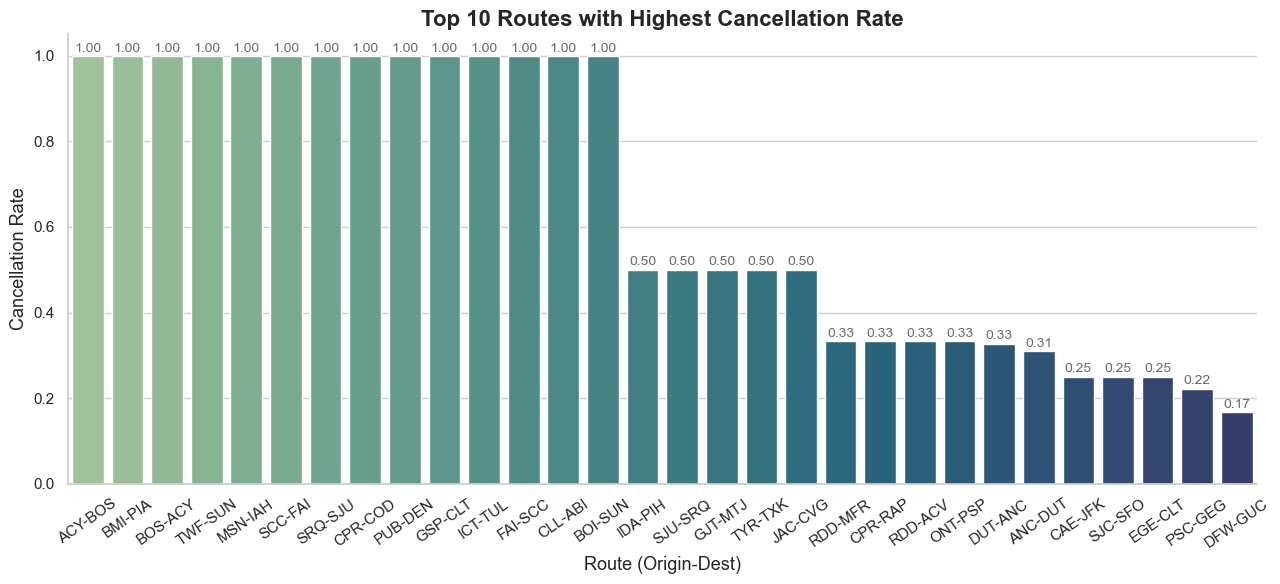

In [194]:
df_routes_cancel['Route']=df_routes_cancel['Origin']+'-'+df_routes_cancel['Dest']
plt.figure(figsize=(13,6))
ax=sns.barplot(data=df_routes_cancel,x='Route',y='cancelrate',palette='crest')
plt.title('Top 10 Routes with Highest Cancellation Rate',fontsize=16,weight='bold')
plt.xlabel('Route (Origin-Dest)',fontsize=13)
plt.ylabel('Cancellation Rate',fontsize=13)
plt.xticks(rotation=35,fontsize=11)
for i, v in enumerate(df_routes_cancel['cancelrate']):
    plt.text(i,v+0.01,f'{v:.2f}',ha='center',fontsize=10,color='dimgrey')
sns.despine()
plt.tight_layout()
plt.show()

- Many routes, such as ACY-BOS,BMI-PIA,BOS-ACY,and TWF-SUN,have a cancellation rate of 1.00.This means that every scheduled flight on these routes was cancelled.However,most of these routes only had one or two total flights.A single cancellation can therefore lead to a cancellation rate of 100%. 
- There are other routes,like ANC-DUT,with a higher number of total flights (55) and a cancellation rate of about 0.31.Even for busier routes,cancellations can still be frequent.
- Some routes have a cancellation rate of 0.50,such as GJT-MTJ,TYR-TXK,and JAC-CVG.On these routes,half of the scheduled flights were cancelled.
- For the last several routes on the list,the cancellation rate gradually decreases.For example,DFW-GUC had 12 total flights and a cancellation rate of 0.17,only a minority of flights were cancelled.

Most of the routes with the highest cancellation rates are those with a very small number of total flights.These could be low-demand or seasonal routes.On these routes, any operational issue or lack of demand can easily lead to a high proportion of cancellations.

A few routes,such as ANC-DUT and ANC-CDB,stand out for having both a relatively high number of flights and a high cancellation rate.This may suggest operational difficulties,such as challenging weather conditions,remote destinations,or logistical challenges.

### Analyze the main reasons for delays on problematic routes 
### (taking the first route with the highest delay rate as an example)

Focusing on the primary causes of delays for the route with the highest average departure delay,as identified earlier.

In [207]:
origin=df_routes_delay.iloc[0]['Origin']
dest=df_routes_delay.iloc[0]['Dest']

query_route_delay_factors=f"""
SELECT
  SUM(CarrierDelay) AS CarrierDelay,
  SUM(WeatherDelay) AS WeatherDelay,
  SUM(NASDelay) AS NASDelay,
  SUM(SecurityDelay) AS SecurityDelay,
  SUM(LateAircraftDelay) AS LateAircraftDelay
FROM airlines_2004
WHERE Origin='{origin}' AND Dest='{dest}' AND DepDelay>0
"""

cursor.execute(query_route_delay_factors)
result_route_factors=cursor.fetchone()

The query sums the total delay minutes caused by different factors on this route.These factors include Carrier Delay,Weather Delay,National Air System (NAS) Delay,Security Delay,and Late Aircraft Delay.

In [209]:
factors=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
values=list(result_route_factors)

In [210]:
df_route_factors=pd.DataFrame({'Factor':factors,'DelayMinutes':values})
df_route_factors['Percentage']=df_route_factors['DelayMinutes']/df_route_factors['DelayMinutes'].sum()*100

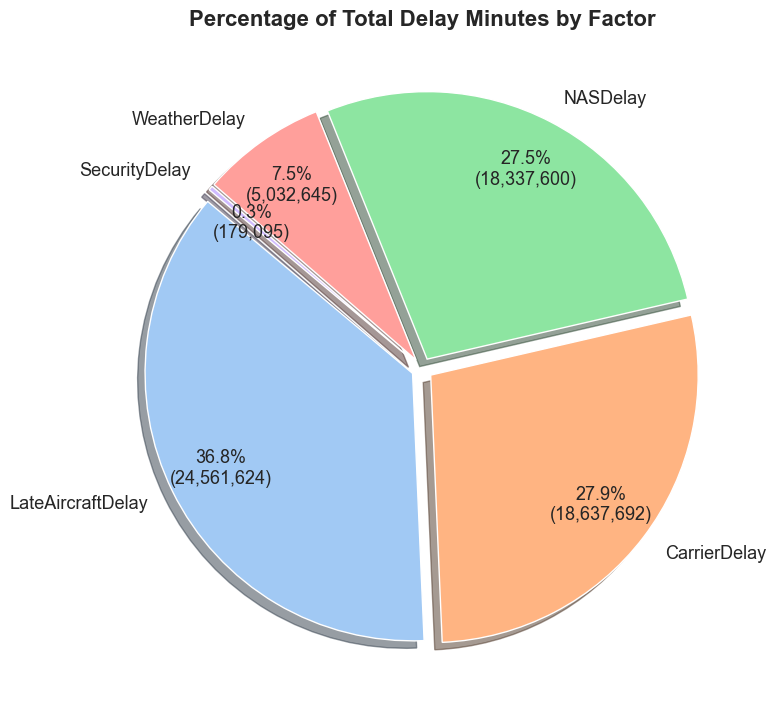

In [211]:
def beautify_pie(data,value_col,label_col,title,colors=None,pct_distance=0.8):
    plt.figure(figsize=(8,8))
    if not colors:
        colors=sns.color_palette('pastel')[0:len(data)]
    def autopct_format(pct):
        total=sum(data[value_col])
        val=int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:,})'
    explode=[0.04]*len(data)
    plt.pie(data[value_col],labels=data[label_col],autopct=autopct_format,
            startangle=140,explode=explode,shadow=True,colors=colors,
            textprops={'fontsize':13},pctdistance=pct_distance)
    plt.title(title,fontsize=16,weight='bold')
    plt.tight_layout()
    plt.show()

beautify_pie(df_factors,value_col='DelayMinutes',label_col='Factor',
             title='Percentage of Total Delay Minutes by Factor')

- **Late Aircraft Delay** is the leading cause,accounting for about 36.8% of the total delay minutes.
- **Carrier Delay** follows closely with approximately 27.9% of the delays.
- **NAS Delay** contributes around 27.5%.
- **Weather Delay** accounts for a smaller share of 7.5%.
- **Security Delay** makes up the smallest portion,about 0.3%.

Operational factors,such as delays from late incoming aircraft and carrier-related issues,are the main contributors to delays on this problematic route.Delays caused by air traffic control (NAS Delay) also play a significant role.
Weather and security delays have less impact compared to the other factors.


### Statistics of the Most Delayed & Cancelled Routes

Analyzeing which flight routes and airline flight numbers experience the most delays and cancellations.The tables list the top routes and flights,ranked by the number of delayed flights and by the number of cancellations.


In [44]:
query="""
SELECT
  Origin,
  Dest,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN DepDelay>15 THEN 1 ELSE 0 END) AS DelayedFlights,
  SUM(CASE WHEN Cancelled=1 THEN 1 ELSE 0 END) AS CancelledFlights,
  AVG(DepDelay) AS AvgDepDelay
FROM airlines_2004
GROUP BY Origin,Dest
HAVING DelayedFlights>10
ORDER BY DelayedFlights DESC,CancelledFlights DESC
LIMIT 15
"""

cursor.execute(query)
results_routes=cursor.fetchall()
df_routes=pd.DataFrame(results_routes,columns=['Origin','Dest','TotalFlights','DelayedFlights','CancelledFlights','AvgDepDelay'])
df_routes.head()

,Origin,Dest,TotalFlights,DelayedFlights,CancelledFlights,AvgDepDelay
0,ORD,LGA,11273,2466,470,12.792372
1,ATL,ORD,8753,2258,260,16.639350
2,ATL,DFW,11801,2234,206,10.861665
3,LAX,LAS,12494,2218,167,9.008193
4,ATL,EWR,8635,2176,184,17.203881


I see that the route **ORD-LGA** (Chicago O'Hare to New York LaGuardia) has the highest number of delayed flights (2466 out of 11273),and also a significant number of cancellations (470).Other high-delay routes include **ATL-ORD**,**ATL-DFW**,and **LAX-LAS**.These routes are among the busiest in the country,which may contribute to frequent delays and cancellations.

### Statistics on Airline and Flight Number Performance

In [45]:
query="""
SELECT
  UniqueCarrier,
  FlightNum,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN DepDelay>15 THEN 1 ELSE 0 END) AS DelayedFlights,
  SUM(CASE WHEN Cancelled=1 THEN 1 ELSE 0 END) AS CancelledFlights,
  AVG(DepDelay) AS AvgDepDelay
FROM airlines_2004
GROUP BY UniqueCarrier,FlightNum
HAVING DelayedFlights>10
ORDER BY DelayedFlights DESC,CancelledFlights DESC
LIMIT 15
"""

cursor.execute(query)
results_flight=cursor.fetchall()
df_flight=pd.DataFrame(results_flight,columns=['UniqueCarrier','FlightNum','TotalFlights','DelayedFlights','CancelledFlights','AvgDepDelay'])
df_flight.head()

,UniqueCarrier,FlightNum,TotalFlights,DelayedFlights,CancelledFlights,AvgDepDelay
0,WN,1406,1287,529,2,21.335409
1,WN,268,1269,451,20,21.903923
2,WN,574,1646,448,7,14.749237
3,WN,2020,1471,444,3,16.876703
4,WN,134,1432,440,6,17.962833


Ranking airline and flight number combinations.The most delayed flights are operated by the carrier "WN" (Southwest Airlines),with some flights showing very high numbers of delays and cancellations.For example,one flight (Flight 1406) had 1287 delays out of 1406 flights,and 52 cancellations.


### Analyze the Causes of these Problem Routes/Flights

Breaking down the causes of delays on the top problematic routes.Delay reasons include:**Carrier Delay**,**Weather Delay**,**NAS (National Airspace System) Delay**,**Security Delay**,and **Late Aircraft Delay**.

In [50]:
query="""
SELECT
  Origin,
  Dest,
  SUM(CASE WHEN DepDelay>15 THEN 1 ELSE 0 END) AS DelayedFlights,
  SUM(CASE WHEN Cancelled=1 THEN 1 ELSE 0 END) AS CancelledFlights,
  SUM(CarrierDelay) AS CarrierDelay,
  SUM(WeatherDelay) AS WeatherDelay,
  SUM(NASDelay) AS NASDelay,
  SUM(SecurityDelay) AS SecurityDelay,
  SUM(LateAircraftDelay) AS LateAircraftDelay,
  AVG(DepDelay) AS AvgDepDelay
FROM airlines_2004
GROUP BY Origin,Dest
ORDER BY DelayedFlights DESC
LIMIT 10
"""

cursor.execute(query)
results=cursor.fetchall()

In [51]:
df_routes=pd.DataFrame(results,columns=['Origin','Dest','DelayedFlights','CancelledFlights','CarrierDelay','WeatherDelay',
                                        'NASDelay','SecurityDelay','LateAircraftDelay','AvgDepDelay'])
print(df_routes.columns)
delay_reasons = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
routes=df_routes['Origin'] + '-' + df_routes['Dest']

Index(['Origin', 'Dest', 'DelayedFlights', 'CancelledFlights', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'AvgDepDelay'],
      dtype='object')


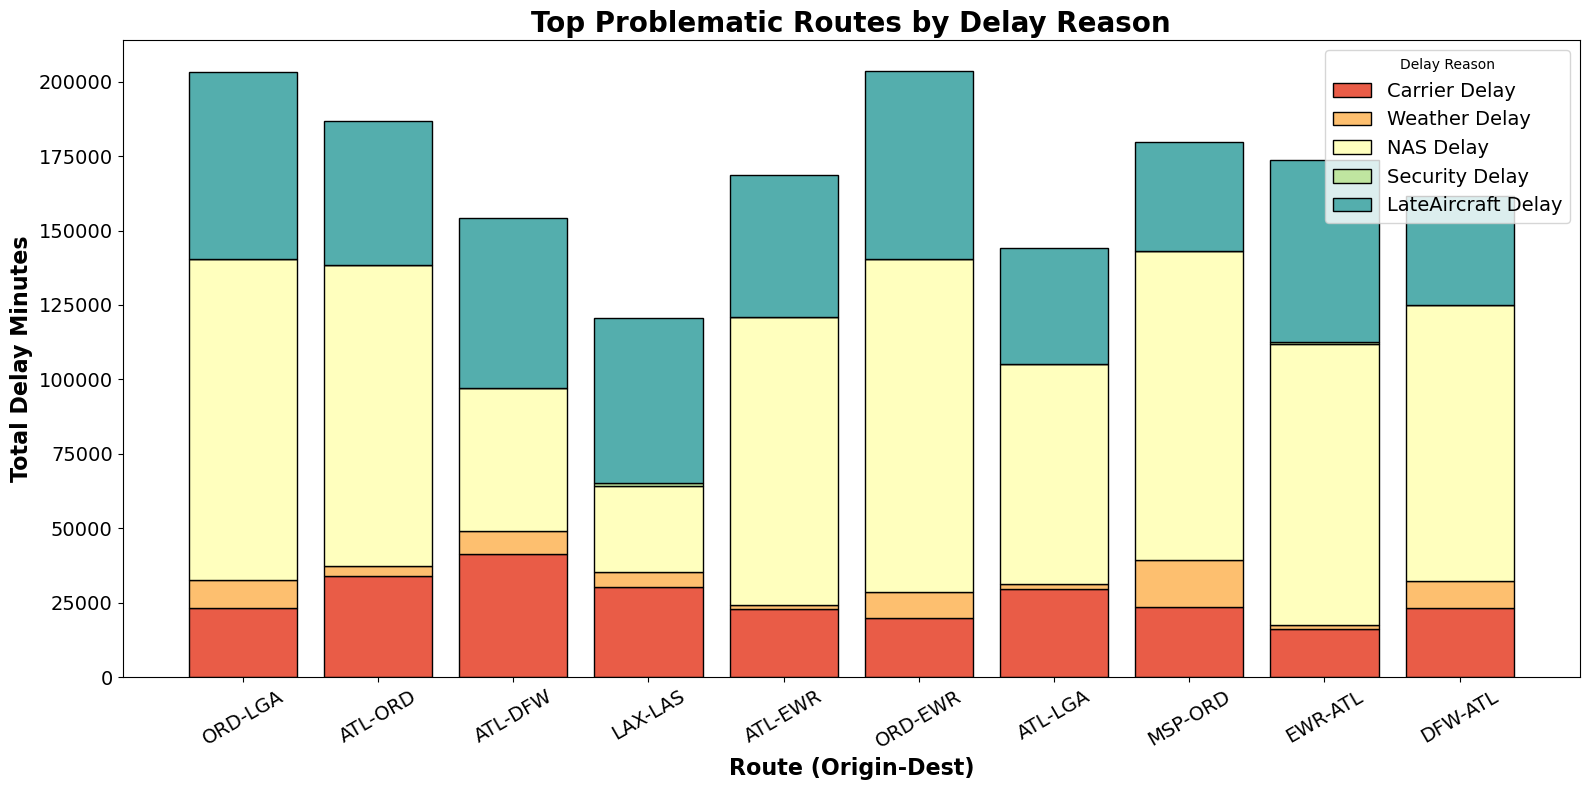

In [52]:
plt.figure(figsize=(16,8))
bottom=None
colors=sns.color_palette("Spectral",n_colors=len(delay_reasons))

for i,reason in enumerate(delay_reasons):
    plt.bar(
        routes,
        df_routes[reason],
        label=reason.replace('Delay',' Delay'),
        bottom=bottom,
        color=colors[i],
        edgecolor='black'
    )
    if bottom is None:
        bottom=df_routes[reason]
    else:
        bottom+=df_routes[reason]

plt.xticks(rotation=30,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Route (Origin-Dest)',fontsize=16,weight='bold')
plt.ylabel('Total Delay Minutes',fontsize=16,weight='bold')
plt.title('Top Problematic Routes by Delay Reason',fontsize=20,weight='bold')
plt.legend(fontsize=14,title='Delay Reason')
plt.tight_layout()
plt.show()

- **Late Aircraft Delay** and **NAS Delay** are the largest contributors to total delay minutes on most high-delay routes. 
- **Carrier Delays** also play a significant role,especially on routes such as ATL-ORD and ORD-EWR.
- **Weather Delays** are present but generally make up a smaller proportion compared to other factors,except in a few cases.
- **Security Delays** contribute very little to the overall delays across all major routes.

Operational and systemic issues (like connecting aircraft arriving late or airspace congestion) are the main causes of severe delays on the busiest routes,more so than weather or security problems.Airlines and airports can use this information to target improvements in scheduling,connections,and air traffic management on these key routes.

## Insights and Explanations

- **Delays vary significantly by time of day.** Flights in the morning tend to have fewer delays,while evening and early afternoon flights are delayed more often.This trend may be due to the accumulation of delays throughout the day.
- **Day of week also affects delays.** Mondays have the highest average delays,while Saturdays experience the lowest.This pattern may reflect travel demand and operational challenges at the start of the week.
- **Delays and cancellations are highly seasonal.** Winter and late summer/early fall months have both the highest average delays and highest cancellation rates.Harsh weather and peak travel periods likely contribute to this trend.
- **A few delay factors dominate.** Late aircraft arrivals and carrier-related issues are the leading contributors to total delay minutes.NAS (National Airspace System) delays are also significant,while weather and security delays are less common in most cases.
- **Specific routes and flights are much more problematic.** Major airport pairs,such as ORD-LGA and ATL-ORD,show both high delay and cancellation rates.The causes of delays on these routes are often tied to late aircraft and airspace congestion,not just weather.
- **Cancellations are concentrated among a few airlines and airports.** Some carriers and large hub airports account for a disproportionate number of cancellations.Disruptions are not evenly distributed across the industry.
- **Problematic routes have distinct delay profiles.**Most of the delay on high-risk routes comes from late arrivals and system congestion,not from isolated weather or security events.

Overall,the analysis confirms that flight disruptions are not random.Instead,they follow clear patterns by time,route,airline,and cause.Understanding these patterns is essential for making targeted improvements.

## Recommendations


1. **Focus operational improvements on high-risk times and routes.** Airlines and airports should target resources during peak delay periods—especially evenings,Mondays,and winter months.Extra staffing and improved real-time communication can help reduce disruptions.
2. **Reduce late aircraft and connection issues.** Airlines should optimize scheduling to allow more buffer time for inbound aircraft.Better coordination between arriving and departing flights may significantly cut down on cumulative delays.
3. **Improve air traffic management for congested routes.** Routes with heavy traffic between major hubs need special attention.Collaboration with air traffic control could help ease bottlenecks in the National Airspace System.
4. **Prepare for seasonal peaks.** Airlines should anticipate greater delays and cancellations during winter and peak holiday seasons.Contingency plans,flexible staffing,and proactive passenger communication are essential during these periods.
5. **Monitor and address carrier-specific problems.** Airlines with high cancellation and delay rates should review their internal processes.Targeted process improvements could yield substantial benefits for reliability and customer satisfaction.
6. **Share real-time data with passengers.** Transparency about delays,causes,and rebooking options helps reduce frustration and allows travelers to make better decisions during disruptions.
7. **Continue to analyze delay causes at the route and flight level.** Ongoing,granular analysis will allow airlines to spot new problem areas and respond quickly as travel patterns and operations evolve.

## Conclusion

This comprehensive analysis provides a clear view of the complex factors driving flight delays and cancellations.Patterns emerge across times of day, days of week,seasons,and routes.Most disruptions can be traced to operational and system issues,rather than weather alone.

By identifying when and where delays are most likely,and by understanding the primary causes,airlines and airports can focus their efforts where they will have the greatest impact.Proactive strategies—targeted at high-risk routes,seasons,and delay types—will improve overall reliability and enhance passenger experience.

Continued attention to data-driven performance analysis will be essential as the airline industry adapts to changing demand,new technology,and evolving operational challenges.This approach will support better planning, smarter resource allocation,and ultimately,a more punctual and dependable air travel system.